In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import and_
from sqlalchemy import or_
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct, desc

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model

In [8]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [9]:
# We can view all of the classes that automap found
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

In [10]:
# reflect the tables

In [11]:
# Save references to each table
Measurement = Base.classes.measurement;
Station     = Base.classes.station; 

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Get the last data point (max date) from the database
max_date = session.query(func.max(Measurement.date)).first()

In [14]:
# convert string max_date to DATE type last_date
last_date = dt.datetime.strptime(max_date[0], '%Y-%m-%d')
#print(last_date)

In [15]:
# Calculate the date 1 year ago from the last data point in the database
one_year_before = last_date - timedelta(days=365)

In [16]:
last_date_str       = last_date.strftime("%Y-%m-%d")
one_year_before_str = one_year_before.strftime("%Y-%m-%d")

#### Design a query to retrieve the last 12 months of precipitation data and plot the results


In [17]:
# Load the results into a pandas dataframe. 
# Save the query results as a Pandas DataFrame and set the index to the date column

results = session.query(Measurement.station, Measurement.prcp, Measurement.date)\
                .filter(and_(Measurement.date >= one_year_before_str, Measurement.date <= last_date_str))

for r in results:
  print (r)

('USC00519397', 0.0, '2016-08-23')
('USC00519397', 0.08, '2016-08-24')
('USC00519397', 0.08, '2016-08-25')
('USC00519397', 0.0, '2016-08-26')
('USC00519397', 0.0, '2016-08-27')
('USC00519397', 0.01, '2016-08-28')
('USC00519397', 0.0, '2016-08-29')
('USC00519397', 0.0, '2016-08-30')
('USC00519397', 0.13, '2016-08-31')
('USC00519397', 0.0, '2016-09-01')
('USC00519397', 0.0, '2016-09-02')
('USC00519397', 0.0, '2016-09-03')
('USC00519397', 0.03, '2016-09-04')
('USC00519397', None, '2016-09-05')
('USC00519397', None, '2016-09-06')
('USC00519397', 0.05, '2016-09-07')
('USC00519397', 0.0, '2016-09-08')
('USC00519397', 0.03, '2016-09-09')
('USC00519397', 0.0, '2016-09-10')
('USC00519397', 0.05, '2016-09-11')
('USC00519397', 0.0, '2016-09-12')
('USC00519397', 0.02, '2016-09-13')
('USC00519397', 1.32, '2016-09-14')
('USC00519397', 0.42, '2016-09-15')
('USC00519397', 0.06, '2016-09-16')
('USC00519397', 0.05, '2016-09-17')
('USC00519397', 0.0, '2016-09-18')
('USC00519397', 0.0, '2016-09-19')
('USC

('USC00519523', 0.0, '2017-03-28')
('USC00519523', 0.08, '2017-03-29')
('USC00519523', 0.0, '2017-03-30')
('USC00519523', 0.0, '2017-03-31')
('USC00519523', 0.0, '2017-04-01')
('USC00519523', 0.0, '2017-04-02')
('USC00519523', 0.0, '2017-04-03')
('USC00519523', 0.0, '2017-04-04')
('USC00519523', 0.0, '2017-04-05')
('USC00519523', 0.0, '2017-04-06')
('USC00519523', 0.0, '2017-04-07')
('USC00519523', None, '2017-04-09')
('USC00519523', 0.0, '2017-04-10')
('USC00519523', 0.0, '2017-04-11')
('USC00519523', 0.0, '2017-04-12')
('USC00519523', 0.0, '2017-04-13')
('USC00519523', 0.36, '2017-04-14')
('USC00519523', 0.0, '2017-04-15')
('USC00519523', 0.0, '2017-04-16')
('USC00519523', 0.3, '2017-04-17')
('USC00519523', 0.15, '2017-04-18')
('USC00519523', 0.0, '2017-04-19')
('USC00519523', 0.35, '2017-04-20')
('USC00519523', 2.36, '2017-04-21')
('USC00519523', None, '2017-04-24')
('USC00519523', 0.0, '2017-04-25')
('USC00519523', 0.01, '2017-04-26')
('USC00519523', 0.0, '2017-04-27')
('USC0051952

In [18]:
df = pd.DataFrame(results[:], columns=['Station', 'Prcp', 'Date'])

### Convert the date column to a Date Type for ease of computation
df['Date'] = pd.to_datetime(df['Date'])
### Set the index to the Date column
df.set_index('Date', inplace=True, )
df.head(100)
df.shape

(2230, 2)

In [19]:
# Sort the dataframe by date
df = df.sort_index(ascending=False)
df.head()

,Station,Prcp
Date,,
2017-08-23,USC00516128,0.45
2017-08-23,USC00519523,0.08
2017-08-23,USC00514830,0.00
2017-08-23,USC00519397,0.00
2017-08-22,USC00519523,0.00


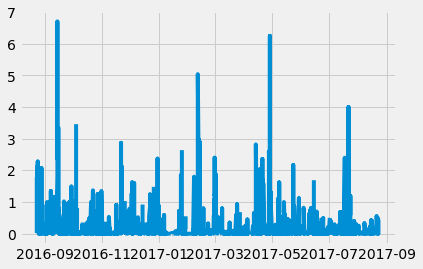

In [20]:
x_values = df.index
y_values = df['Prcp']

ax = plt.gca()

plt.plot(x_values, y_values)
#plot values

plt.show()

In [21]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [22]:
# Design a query to show how many stations are available in this dataset?
#print(Station.__dict__.keys())

num_stations = session.query(func.count(Station.station)).first()
print(f"There are {num_stations[0]} stations available in this dataset ")


There are 9 stations available in this dataset 


In [23]:
number_of_stations = session.query(func.count(distinct(Measurement.station))).first()
print(f"There are {number_of_stations[0]} stations available in this dataset")

There are 9 stations available in this dataset


In [24]:
# results = session.query(Station.id, Station.station, Station.name).\
#     order_by(Station.id.desc()).all()

# for r in results:
#   print(r)

In [25]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

##### COME BACK AND DO STATION NAME IN. HERE 
most_active_stations = session.query(Measurement.station, func.count(Measurement.station))\
.group_by(Measurement.station).order_by(desc(func.count(Measurement.station)))

#for station in most_active_stations:
#    print(station)
    
station_count_df = pd.DataFrame(most_active_stations[:], columns=['Station', 'Station Count'])
station_count_df

,Station,Station Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_id = station_count_df.iloc[0]['Station']
print(station_id)

low_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == station_id).first()
print(low_temp[0])
high_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == station_id).first()
print(high_temp[0])
# print(Measurement.__dict__.keys())
# print(Station.__dict__.keys())


USC00519281
54.0
85.0


In [27]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
high_temp = session.query(Measurement.station, func.count(Measurement.tobs)).\
            filter(and_(Measurement.date >= one_year_before_str, Measurement.date <= last_date_str))


In [28]:
highest_temp_obs = session.query(Measurement.station, Measurement.tobs, func.count(Measurement.tobs))\
                    .group_by(Measurement.station).order_by(desc(func.count(Measurement.tobs)))
# for h in highest_temp_obs:
#     print (h)
station_tobs = highest_temp_obs[0][0]

my_df = df[df['Station']==station_tobs]
my_df
for h in highest_temp_obs:
    print (h)

('USC00519281', 70.0, 2772)
('USC00519397', 65.0, 2724)
('USC00513117', 67.0, 2709)
('USC00519523', 75.0, 2669)
('USC00516128', 73.0, 2612)
('USC00514830', 67.0, 2202)
('USC00511918', 66.0, 1979)
('USC00517948', 75.0, 1372)
('USC00518838', 72.0, 511)


In [29]:
# print(Station.__dict__.keys())
# print(Measurement.__dict__.keys())

In [30]:

results = session.query(Measurement.station, Measurement.prcp, Measurement.tobs, Measurement.date)\
                .filter(and_(Measurement.date >= one_year_before_str, Measurement.date <= last_date_str))


temperature_obs_df = pd.DataFrame(results[:], columns=['Station', 'P', 'Temperature', 'date'])

for t in temperature_obs_df:
    print(t)
    
temperature_obs_df

Station
P
Temperature
date


,Station,P,Temperature,date
0,USC00519397,0.00,81.0,2016-08-23
1,USC00519397,0.08,79.0,2016-08-24
2,USC00519397,0.08,80.0,2016-08-25
3,USC00519397,0.00,79.0,2016-08-26
4,USC00519397,0.00,77.0,2016-08-27
...,...,...,...,...
2225,USC00516128,0.09,71.0,2017-08-19
2226,USC00516128,NaN,78.0,2017-08-20
2227,USC00516128,0.56,76.0,2017-08-21
2228,USC00516128,0.50,76.0,2017-08-22


In [31]:
ddf = temperature_obs_df.groupby(pd.DatetimeIndex(df.index).month).mean()
ddf

,P,Temperature
Date,,
1,0.111629,75.554974
2,0.108788,74.757062
3,0.138954,77.613757
4,0.096879,76.752632
5,0.186552,71.022989
6,0.063979,76.884817
7,0.062629,72.335052
8,0.158227,76.746667
9,0.353258,70.531579


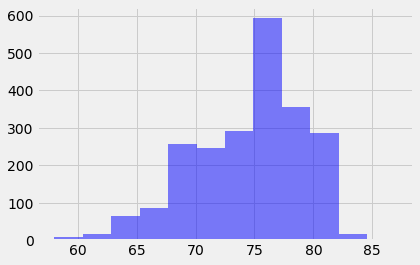

In [32]:
x = temperature_obs_df['Temperature']
num_bins = 12
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5, )
plt.show()

In [33]:
# dates = my_df.index
# dates

## Bonus Challenge Assignment

In [34]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
#print(calc_temps('2012-02-28', '2012-03-05'))

In [35]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_date = pd.to_datetime('2017-07-23')
trip_end_date   = pd.to_datetime('2017-08-08')

one_year_before_start = trip_start_date - timedelta(days=365)
one_year_before_end   = trip_end_date   - timedelta(days=365)

one_year_before_start = one_year_before_start.strftime("%Y-%m-%d")
one_year_before_end   = one_year_before_end.strftime("%Y-%m-%d")

#print(calc_temps(one_year_before_start, one_year_before_end))
prev_year = calc_temps(one_year_before_start, one_year_before_end)
tmin = prev_year[0][0]
tavg = prev_year[0][1]
tmax = prev_year[0][2]

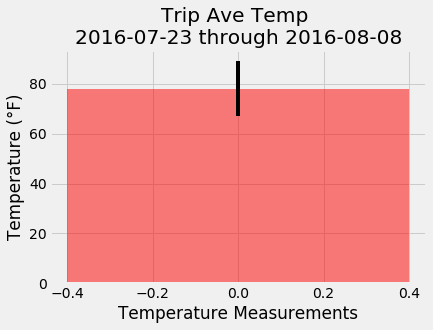

In [36]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

peak_to_peak = tmax - tmin

plt.bar(0, tavg, color = 'r', alpha = 0.5, align='center', yerr=peak_to_peak)

plt.xlabel( 'Temperature Measurements')
plt.ylabel(u'Temperature (\N{DEGREE SIGN}F)')
plt.title ( f'Trip Ave Temp \n{one_year_before_start} through {one_year_before_end}')

plt.show()


In [37]:
# This function called `calc_rainfall` will accept start date and end date in the format '%Y-%m-%d' 
# and return the total amount of rainfall for that range of dates
def calc_rainfall(start_date, end_date):
    """STATION, NAME, LATITUDE, LONGITUDE, ELEVATION, and PRECIPTIATION for a list of rainfall.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        STATION, NAME, LATITUDE, LONGITUDE, ELEVATION, and PRECIPTIATION 
    """
    
#     
    return session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation,\
         func.sum(Measurement.prcp)).group_by(Station.name).filter(Station.station == Measurement.station)\
        .filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
# function usage example
#print(calc_temps('2012-02-28', '2012-03-05'))

In [38]:
# Calculate the total amount of rainfall per weather station for your trip dates 
# using the previous year's matching dates.
# Sort this in descending order by precipitation amount a
# and list the station, name, latitude, longitude, and elevation


#print(calc_rainfall(one_year_before_start, one_year_before_end))
rain_results = calc_rainfall(one_year_before_start, one_year_before_end)

rainfall_df = pd.DataFrame(rain_results[:], columns=['Station', 'Name', 'Latitute',\
                                                     'Longitude', 'Elevation', 'Precipitation'])

#df.groupby('Station').sum()
rainfall_df

rainfall_df.sort_values(by=['Precipitation'], ascending=False)

,Station,Name,Latitute,Longitude,Elevation,Precipitation
4,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,17.55
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,16.19
0,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,11.98
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,5.36
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,4.98
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.10
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.19


In [39]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [93]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start_date = pd.to_datetime('2017-07-23')
trip_end_date   = pd.to_datetime('2017-08-08')

# Use the start and end date to create a range of dates
range_of_dates = pd.date_range(start=trip_start_date, end=trip_end_date)
#range_of_dates


# Strip off the year and save a list of %m-%d strings
dates_list = []
for r in range_of_dates:
    #print(r.strftime("%m-%d"))
    dates_list.append(r.strftime("%m-%d"))

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for day in dates_list:
    dn = daily_normals(day)
    normals.append([dn[0][0],dn[0][1], dn[0][2]])


In [94]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_dates = pd.DataFrame(normals, columns = ['Min', 'Ave', 'Max'], index = dates_list)
trip_dates
#pd.DataFrame({'email':sf.index, 'list':sf.values}

,Min,Ave,Max
07-23,70.0,76.203704,84.0
07-24,69.0,76.555556,81.0
07-25,67.0,76.890909,84.0
07-26,71.0,76.442308,86.0
07-27,68.0,76.581818,83.0
07-28,69.0,76.464286,82.0
07-29,69.0,76.470588,83.0
07-30,69.0,77.351852,84.0
07-31,72.0,77.035714,83.0
08-01,67.0,75.540000,83.0


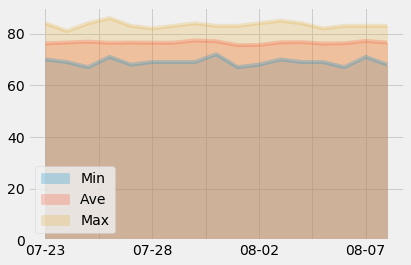

In [99]:
# Plot the daily normals as an area plot with `stacked=False`
ax = trip_dates.plot.area(stacked=False, alpha=0.25)

# End of Notebook 